<a href="https://colab.research.google.com/github/marlapinkert/TEWA2/blob/main/05_Preprocessing_Nipype.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing with Nipype
Today, we will continue learning how to do preprocessing using Nipype. We will perform brain extraction of an anatomical image, and normalization to the MNI template. Today, we will omit the group exercises - this is because you will start working on your individual assignments instead.

Objectives:
- practicing Nipype skills
- learning how to preprocess anatomical data


## Setting up our environment
As we did last week, we will be using Neurodesk. You can use the cell below to install it.

In [ ]:
import os
os.environ["LD_PRELOAD"] = "";
os.environ["APPTAINER_BINDPATH"] = "/content"
os.environ["LMOD_CMD"] = "/usr/share/lmod/lmod/libexec/lmod"

!curl -J -O https://raw.githubusercontent.com/NeuroDesk/neurocommand/main/googlecolab_setup.sh
!chmod +x googlecolab_setup.sh
!./googlecolab_setup.sh
os.environ["MODULEPATH"] = ':'.join(map(str, list(map(lambda x: os.path.join(os.path.abspath('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/'), x),os.listdir('/cvmfs/neurodesk.ardc.edu.au/neurodesk-modules/')))))

import lmod
await lmod.load('fsl/6.0.4')


os.environ["FSLOUTPUTTYPE"] = "NIFTI_GZ"

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3356  100  3356    0     0  10833      0 --:--:-- --:--:-- --:--:-- 10825
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
lsb-release is already the newest version (11.1.0ubuntu4).
lsb-release set to manually installed.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
--2024-11-06 20:53:05--  https://ecsft.cern.ch/dist/cvmfs/cvmfs-release/cvmfs-release-latest_all.deb
Resolving ecsft.cern.ch (ecsft.cern.ch)... 188.184.97.7
Connecting to ecsft.cern.ch (ecsft.cern.ch)|188.184.97.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5284 (5.2K)
Saving to: ‘cvmfs-release-latest_all.deb’

cvmfs-release-lates 100%[===================>]   5.16K  --.-KB/s    in 0s      

2024-11-06 20:53:06 (235 MB/s) - ‘cvmfs-release-latest_all.deb’ saved [5284/5284

We will also use the same data as we did last week: the NYU Slow Flanker dataset from Openneuro. In this study, healthy adults underwent MRI scanning while performing an event-related Eriksen Flanker task. We specify -d /data so the data is saved in our data folder.



In [ ]:
# download dataset
!gdown 1YP7UtrbsFCCEYxvuY5D3DMiOh7pXyRWJ
!unzip /content/ds000102.zip -d /data

%cd /data

Downloading...
From (original): https://drive.google.com/uc?id=1YP7UtrbsFCCEYxvuY5D3DMiOh7pXyRWJ
From (redirected): https://drive.google.com/uc?id=1YP7UtrbsFCCEYxvuY5D3DMiOh7pXyRWJ&confirm=t&uuid=c2b607b4-94b6-41b5-91b1-4f3cfcfcbc92
To: /content/ds000102.zip
100% 204M/204M [00:03<00:00, 51.6MB/s]
Archive:  /content/ds000102.zip
   creating: /data/ds000102/
  inflating: /data/ds000102/task-flanker_bold.json  
  inflating: /data/ds000102/.DS_Store  
  inflating: /data/ds000102/CHANGES  
   creating: /data/ds000102/sub-01/
  inflating: /data/ds000102/README   
  inflating: /data/ds000102/dataset_description.json  
  inflating: /data/ds000102/T1w.json  
  inflating: /data/ds000102/participants.tsv  
   creating: /data/ds000102/sub-02/
   creating: /data/ds000102/sub-03/
  inflating: /data/ds000102/sub-01/.DS_Store  
   creating: /data/ds000102/sub-01/anat/
   creating: /data/ds000102/sub-01/func/
   creating: /data/ds000102/sub-02/anat/
   creating: /data/ds000102/sub-02/func/
   creating:

## Brain extraction & Normalization
Last week, we took our first preprocessing functional files. Today, we look at the anatomical files. Specifically, we will perform **brain extraction** and then a non-linear transformation of the anatomical file to the MNI template. This is also called **normalization**.

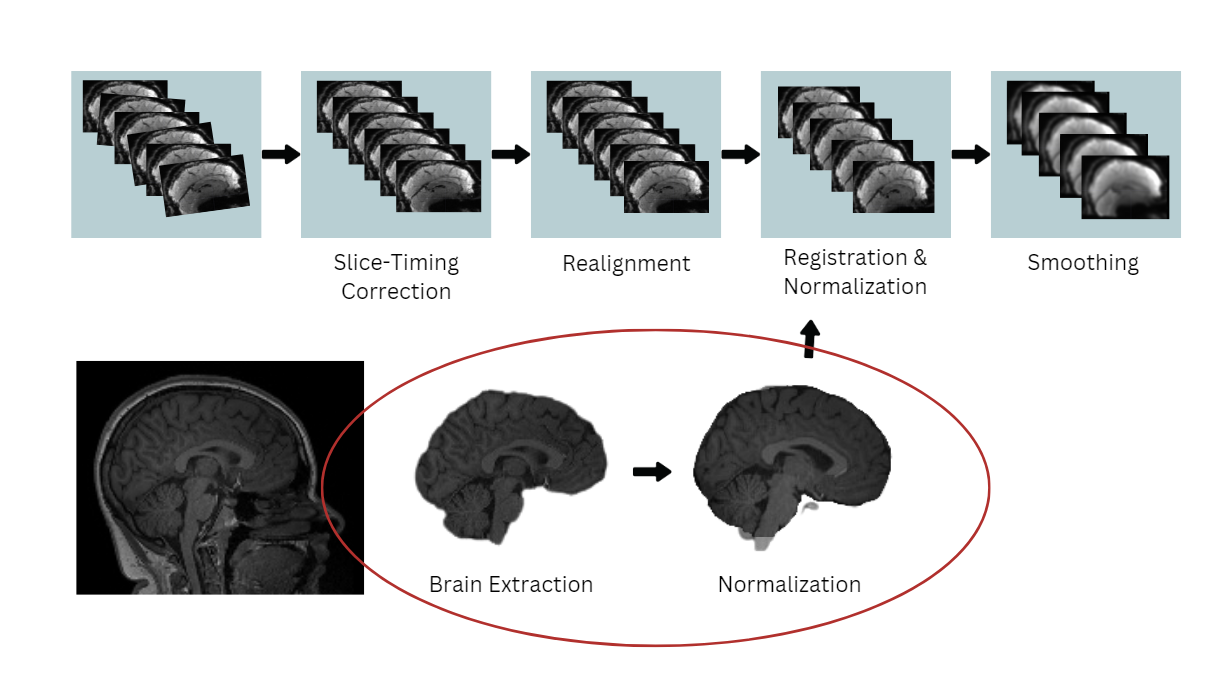

#### Brain Extraction
There are different tools we can use for brain extraction, for today, we will stick with FSL's **bet**. I have previously achieved better results using ANTs' BrainExtraction, however, it has the downside of taking much longer to run. It also always depends on your data - we always have to check our results!

First, I create a variable that points to my anatomical file.

In [ ]:
anat = "/data/ds000102/sub-01/anat/sub-01_T1w.nii.gz"

Then, let's use an Nipype interface for brain extraction! In this case, it is simply called `fsl.BET`

In [ ]:
from nipype.interfaces import fsl

btr = fsl.BET(in_file = anat)

We have now instantiated our object. Let's run it!

In [ ]:
res = btr.run()

We have now saved the result of our Nipype interface in the variable called res. This is very useful - I will show you why:

In [ ]:
res.outputs


inskull_mask_file = <undefined>
inskull_mesh_file = <undefined>
mask_file = <undefined>
meshfile = <undefined>
out_file = /data/sub-01_T1w_brain.nii.gz
outline_file = <undefined>
outskin_mask_file = <undefined>
outskin_mesh_file = <undefined>
outskull_mask_file = <undefined>
outskull_mesh_file = <undefined>
skull_file = <undefined>
skull_mask_file = <undefined>

We can access the `outputs` attribute of our Interface result. If we want to access the output - the brain-extracted file - directly, we can specify it as below, which will return its path. Note: most of the time, the most "important" output file in a Nipype interface result is called "`out_file`". However, this is not always the case! You can always check by looking at the documentation.

In [ ]:
res.outputs.out_file

'/data/sub-01_T1w_brain.nii.gz'

While we usually should now where our data ends up, it can be convenient to be able to look it up with the outputs attribute. Lost files aside, you might have noticed how Nipype gives new file name endings to preprocessed files. This is important to be able to distinguish these files. However, if you are not 100% certain what the output of your tool will be named, you can use the above strategy to write your code without manually opening up your file browser to check the file names at each step.

Let's use this to plot our brain extracted file!

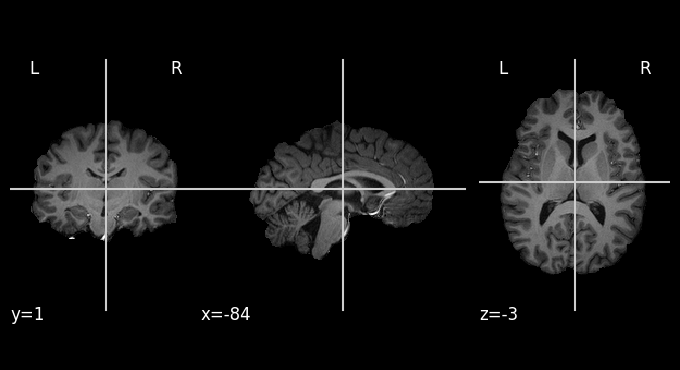

In [ ]:
from nilearn import plotting

plotting.plot_anat(
    res.outputs.out_file,
    dim = -1 # this increases contrast
    )

Now, how do we find out whether this is "good"? One option is to plot the brain-extracted and non-brain-extracted files together.

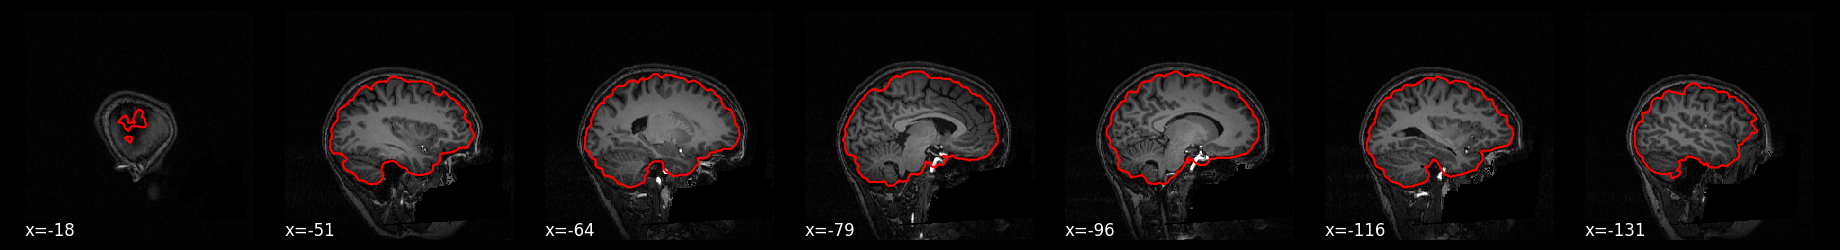

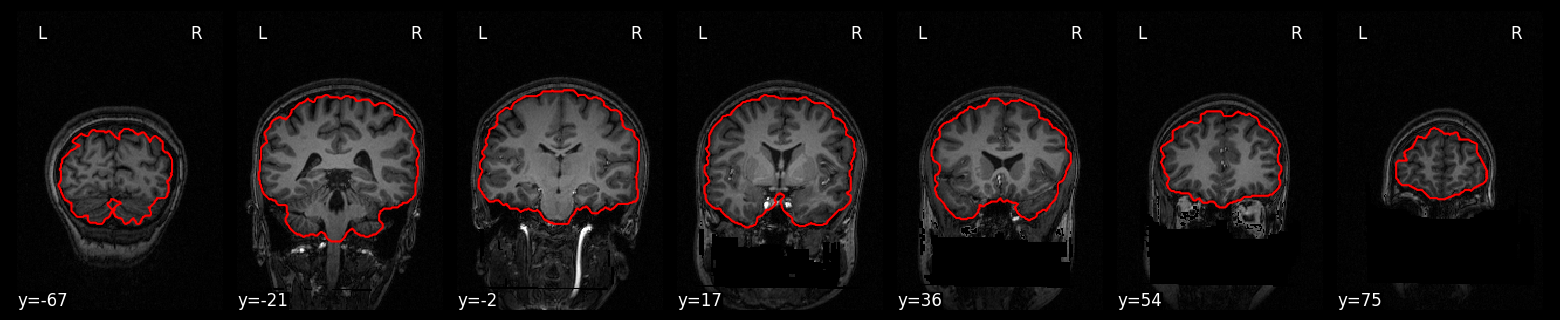

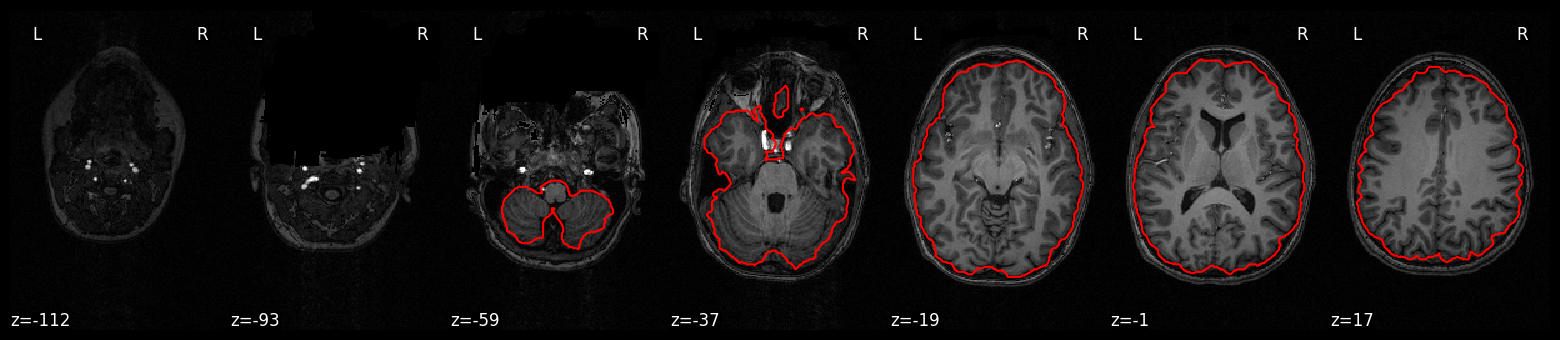

In [ ]:
from nilearn import plotting


for cut in ["x","y","z"]:
    display = plotting.plot_anat(
        anat,
        display_mode = cut,
        dim = -1 # this increases contrast
        )

    display.add_contours(res.outputs.out_file, levels=[1], colors="r")

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: UserWarning: Warning: converting a masked element to nan.
  _data = np.array(data, dtype=dtype, copy=copy,


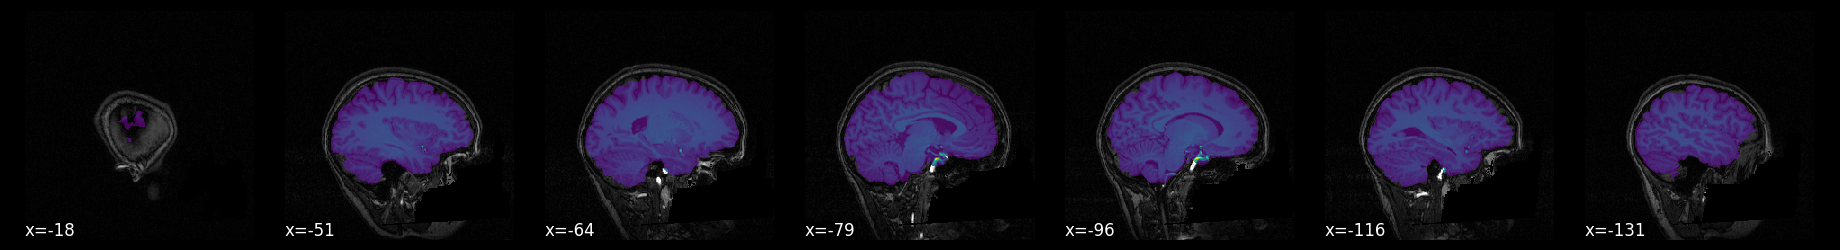

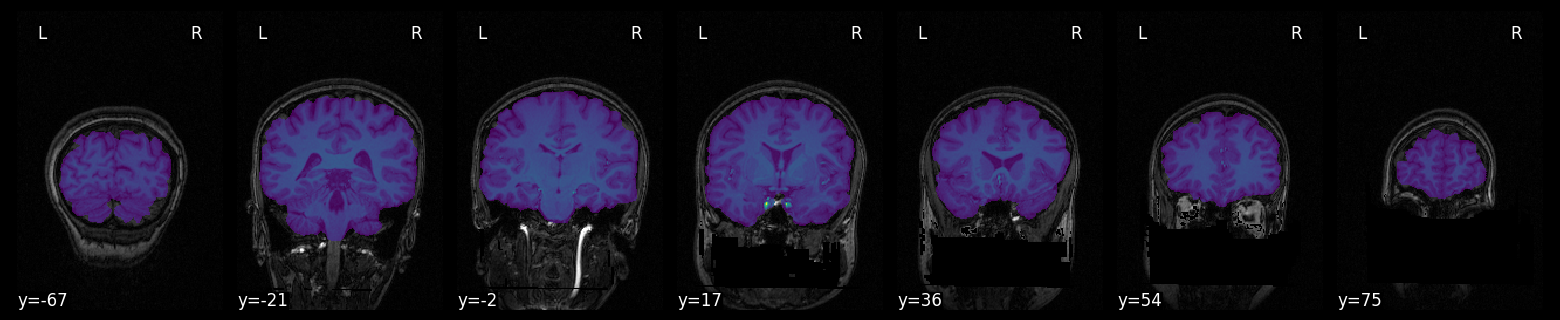

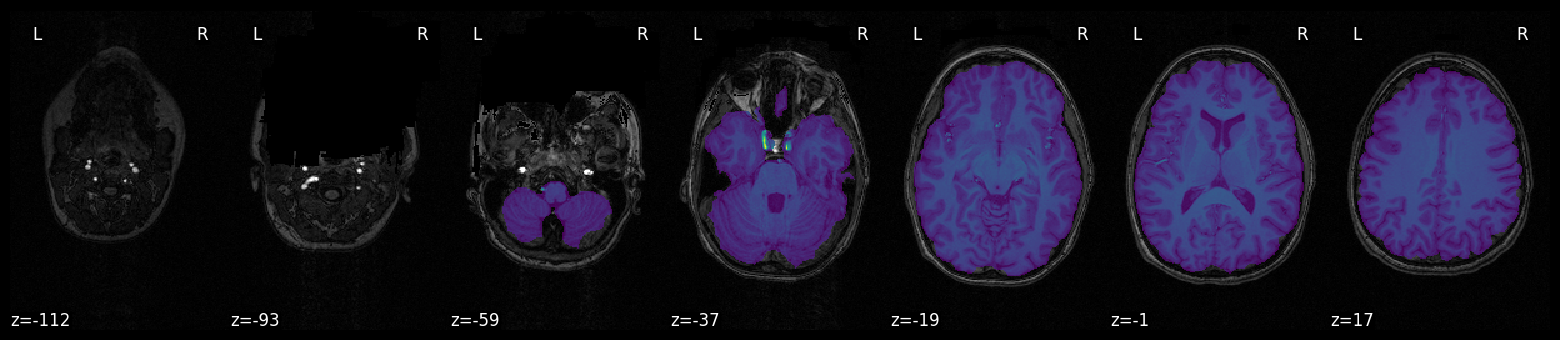

In [ ]:
from nilearn import plotting


for cut in ["x","y","z"]:
    display = plotting.plot_anat(
        anat,
        display_mode = cut,
        dim = -1 # this increases contrast
        )

    display.add_overlay(res.outputs.out_file)

#### Normalization
Same as with brain extraction, there are different tools we can use for normalization. We will still stick with FSL, using **`FNIRT`**.

Normalization means that we warp and move the anatomical file in such a way that it corresponds to a **template** - usually the [MNI template](https://www.lead-dbs.org/about-the-mni-spaces/). This makes it possible to compare brain activity in different subjects, as now, in our matrices, one voxel for one subject should be the same as for the other ones. However, if it is possible for our research question, we can also analyse our data in "subject space", meaning we do not transform it. This is more accurate.

The MNI template is automatically downloaded with FSL, and we find it somewhere deep in the `/cmfs` directory. I have copied it into `/data` so we can find it more easily.

In [ ]:
!cp /cvmfs/neurodesk.ardc.edu.au/containers/fsl_6.0.4_20210105/fsl_6.0.4_20210105.simg/opt/fsl-6.0.4/data/standard/MNI152_T1_2mm_brain.nii.gz /data


In [ ]:
mni_template = "/data/sub-01_T1w_brain.nii.gz"

When "transforming" our images, we can do l**inear and non-linear transformations**.

**Linear transformations** do not warp the images, but simply move them. If we want to align our functional to our anatomical file, we can use a linear transformation. During motion correction with `MCFLIRT`, we actually perform many linear transformations when all volumes are aligned to the middle volume. If we wanted to perform a singular linear transformation, we could use `FLIRT`.

**Non-linear transformations** warp the images. This is necessary when we are trying to change our anatomical image to exactly fit the standard template. Therefore, we will do a non-linear transformation using `FNIRT` next :)

In [ ]:
fnirt = fsl.FNIRT(
    in_file = res.outputs.out_file,
    ref_file = mni_template
    )

In [ ]:
fnirt_res = fnirt.run()

Let's see what files this procedure resulted in:

In [ ]:
fnirt_res.outputs


field_file = <undefined>
fieldcoeff_file = <undefined>
jacobian_file = <undefined>
log_file = /data/sub-01_T1w_brain_log.txt
modulatedref_file = <undefined>
out_intensitymap_file = <undefined>
warped_file = /data/sub-01_T1w_brain_warped.nii.gz

We are interested in the warped file. Let's plot it:

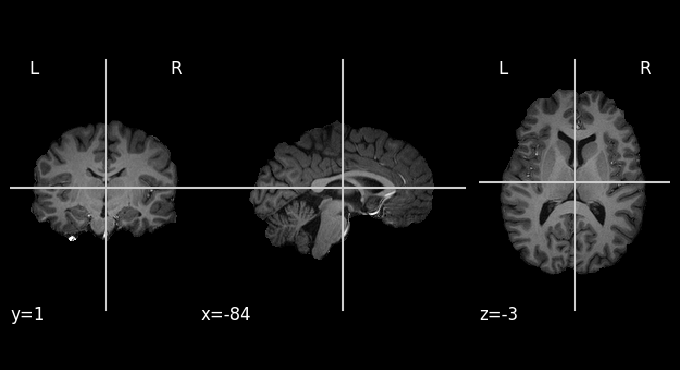

In [ ]:
display = plotting.plot_anat(
    fnirt_res.outputs.warped_file ,
    #display_mode = cut,
    dim = -1 # this increases contrast
    )

To check how well this worked, we can again add contours or an overlay.

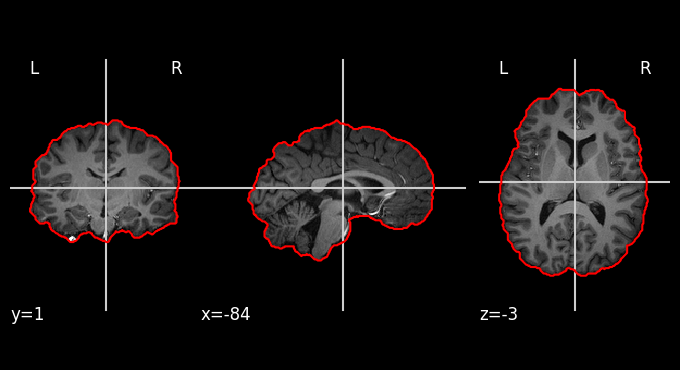

In [ ]:
display = plotting.plot_anat(
    fnirt_res.outputs.warped_file ,
    dim = -1
    )

display.add_contours(mni_template, levels=[1], colors="r")

To truly check how well normalization works, I prefer opening the files in a program such as FSLEYES to be able to "zoom" through different slices while turning the overlay on and off.

A last bit of input on how we will proceed: In your individual assignments, you will preprocess a functional file. Therefore, you will do **slicetiming correction, motion correction**, and **smoothing**. You won't need to do any normalization/coregistration, as we will stay in "subject space" as opposed to transforming our files to "mni space". Still, if you were to perform these steps as well, you would probably do either of these:
1. Coregister the functional to the anatomical file. Normalize the anatomical to the MNI template. Use the parameters from these two transformations to transform the functional files to the MNI template.

OR

2. Immediately do a non-linear transformation of the functional file to the MNI template.

## Exercise

### Preprocessing the Functional File
Your task is to:

1. **Calculate additional motion parameters** (`fsl.MotionOutliers`) -> This should be done on the raw file
2. **Perform slicetiming correction** (`fsl.SliceTimer`) -> This should be done on the raw file.
  
  **Note:** Although this information is lacking in the NIfTI header, we know from [Mennes et al. (2011)]( https://doi.org/10.1016/j.neuroimage.2010.10.046) that the study used an interleaved acquisition order. Make sure to specify this!
3. **Perform Motion correction** (`fsl.MCFLIRT`) -> This should be done on the slicetime-corrected file.

  **Note:** Make sure to save the motion parameters, so you can plot them later!
4. **Perform Smoothing** (`fsl.IsotropicSmooth`) -> This should be done on the motion-corrected file..

   **Note**: Make sure to specify an FWHM  of 6.

Tip 1: Using Nipype within Colab can cause issues if paths are not specified in a certain way. You are usually on the safe side if you provide the absolute path.



### Plotting Preprocessed Images
Plot both the raw and preprocessed images. Make sure to set a title for each. Comment on which differences you observe.